In [9]:
#importing csv file for the classes
import pandas as pd
metadata = pd.read_csv('list1.csv')
metadata.head()

,filename,category
0,fan-normal_id_01_00000000 .wav,fan
1,fan-normal_id_01_00000001 .wav,fan
2,fan-normal_id_01_00000002 .wav,fan
3,fan-normal_id_01_00000003 .wav,fan
4,fan-normal_id_01_00000004 .wav,fan


In [10]:
#class distribution
print(metadata.category.value_counts())

toycar         2370
pump           2370
fan            2370
toyconveyor    2370
slider         2370
valve          2370
Name: category, dtype: int64


### Iterate through each audio file and extract, number of audio channels, sample rate and bit-depth.

In [11]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('E://Repos//Tau_Task2-dataset'),str(row["filename"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [12]:
# num of channels 

print(audiodf.num_channels.value_counts(normalize=True))

1    1.0
Name: num_channels, dtype: float64


In [13]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

16000    1.0
Name: sample_rate, dtype: float64


In [14]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


## Extracting a MFCC
#### For this we will use Librosa's mfcc() function which generates an MFCC from time series audio data.

In [25]:
import librosa 
import numpy as np

#lets find mfcc for one file only

filename = 'E://Repos//Tau_Task2-dataset//fan-normal_id_01_00000000 .wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 431)


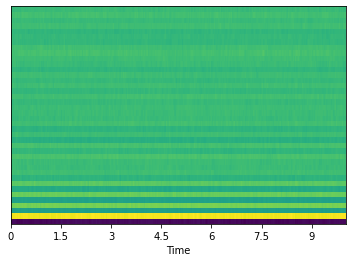

In [26]:
#showing mfccs of the given sample 
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='viridis')

(40, 474)


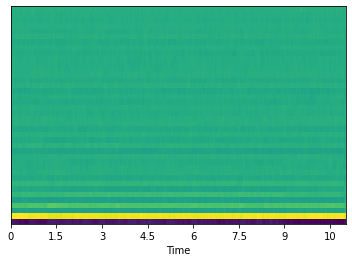

In [36]:
#showing mfccs of the given sample 

filename = 'E://Repos//Tau_Task2-dataset//toycar-normal_id_05_00000344 .wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='viridis')


(40, 474)


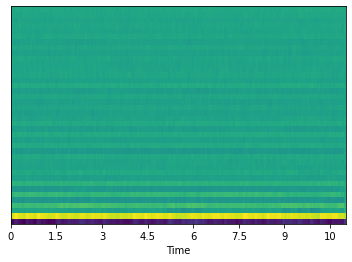

In [39]:
#showing mfccs of the given sample 

filename = 'E://Repos//Tau_Task2-dataset//toycar-normal_id_05_00000436 .wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='viridis')




In [40]:
#function to extract MFCC for all files
import numpy as np
max_pad_len = 480

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [41]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'E://Repos//Tau_Task2-dataset'

metadata = pd.read_csv('list1.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),str(row["filename"]))
    
    class_label = row["category"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  14220  files


In [42]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [43]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## CNN model

In [44]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 480
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [45]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [46]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 479, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 239, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 239, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 238, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 119, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 119, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 118, 64)       

## Training

In [50]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 10
#num_batch_size = 128
# train: 79.7%
#test : 80.8%

num_epochs = 16
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 11376 samples, validate on 2844 samples
Epoch 1/16
11376/11376 [==============================] - 118s 10ms/step - loss: 0.1907 - accuracy: 0.9339 - val_loss: 0.4980 - val_accuracy: 0.8368

Epoch 00001: val_loss improved from inf to 0.49796, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 2/16
11376/11376 [==============================] - 121s 11ms/step - loss: 0.1789 - accuracy: 0.9382 - val_loss: 0.4847 - val_accuracy: 0.8439

Epoch 00002: val_loss improved from 0.49796 to 0.48467, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 3/16
11376/11376 [==============================] - 122s 11ms/step - loss: 0.1894 - accuracy: 0.9335 - val_loss: 0.4960 - val_accuracy: 0.8182

Epoch 00003: val_loss did not improve from 0.48467
Epoch 4/16
11376/11376 [==============================] - 122s 11ms/step - loss: 0.1864 - accuracy: 0.9332 - val_loss: 0.4816 - val_accuracy: 0.8383

Epoch 00004: val_loss improved from 0.48467 to 0.48157, saving model to saved_

In [51]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.905414879322052
Testing Accuracy:  0.8966244459152222


(40, 431)


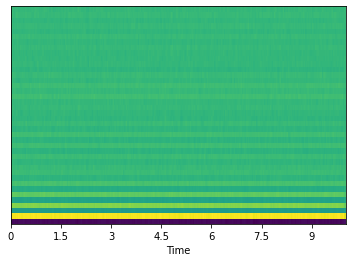

In [62]:
##  Testing 
filename = 'E://temp_tau//fan-normal_id_05_00000524 .wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time', cmap='viridis')




In [54]:
# prediction function
import numpy as np
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [63]:

filename = 'E://temp_tau//fan-normal_id_05_00000524 .wav' 
print_prediction(filename) 

The predicted class is: fan 

fan 		 :  0.99958509206771850585937500000000
pump 		 :  0.00033056989195756614208221435547
slider 		 :  0.00007249464397318661212921142578
toycar 		 :  0.00000011453725079491050564683974
toyconveyor 		 :  0.00000223220877160201780498027802
valve 		 :  0.00000949150671658571809530258179


In [64]:

filename = 'E://temp_tau//valve-normal_id_05_00000777 .wav' 
print_prediction(filename)

The predicted class is: slider 

fan 		 :  0.00981226377189159393310546875000
pump 		 :  0.23897150158882141113281250000000
slider 		 :  0.67220932245254516601562500000000
toycar 		 :  0.00000118151695005508372560143471
toyconveyor 		 :  0.00002388438952038995921611785889
valve 		 :  0.07898185402154922485351562500000


In [65]:
filename = 'E://temp_tau//toyconveyor-normal_id_06_00000476 .wav' 
print_prediction(filename)

The predicted class is: toyconveyor 

fan 		 :  0.00000785305019235238432884216309
pump 		 :  0.00000006402477481515234103426337
slider 		 :  0.00047160021495074033737182617188
toycar 		 :  0.00012793445785064250230789184570
toyconveyor 		 :  0.99938941001892089843750000000000
valve 		 :  0.00000307006803268450312316417694
